## Contents

This notebook analyses lag-frequency spectrums of the light curves simulated through impulse response approach. First, a simple case with delta impulse response is covered. Subsequently, an energy-dependent impulse response scenario is analysed.

## Setup

Import some useful libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Import relevant stingray libraries.

In [2]:
from stingray import Lightcurve, Crossspectrum, sampledata
from stingray.simulator import simulator, models

## Initializing

Instantiate a simulator object and define a variability signal.

In [3]:
var = sampledata.sample_data()

# Beware: set tstart here, or nothing will work!
sim = simulator.Simulator(N=1024, mean=0.5, dt=0.125, rms=0.4, tstart=var.tstart)


For ease of analysis, define a simple delta impulse response with width 1. Here, `start` parameter refers to the lag delay, which we will soon see.

In [4]:
delay = 10
s_ir = sim.simple_ir(start=delay, width=1)

Finally, simulate a `filtered` light curve. Here, filtered means that the initial lag delay portion is cut.

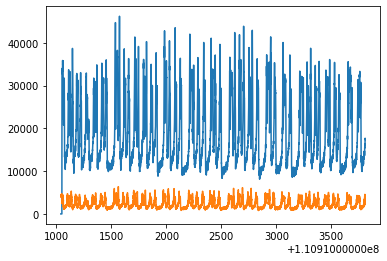

In [5]:
lc = sim.simulate(var.counts, s_ir)

plt.plot(lc.time, lc.counts)
plt.plot(var.time, var.counts)

# Analysis

Compute crossspectrum.

In [6]:
cross = Crossspectrum(var, lc)

Rebin the crosss-spectrum for ease of visualization.

In [7]:
cross = cross.rebin(0.0050)

Calculate time lag.

In [8]:
lag = cross.time_lag()

Plot lag.

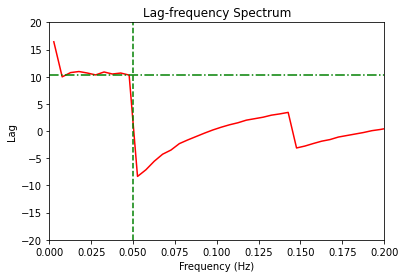

In [9]:
plt.figure()

# Plot lag-frequency spectrum.
plt.plot(cross.freq, lag, 'r')

# Find cutoff points
v_cutoff = 1.0/(2*delay)
h_cutoff = lag[int((v_cutoff-0.0050)*1/0.0050)]

plt.axvline(v_cutoff, color='g',linestyle='--')
plt.axhline(h_cutoff, color='g', linestyle='-.')

# Define axis
plt.axis([0,0.2,-20,20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Lag')
plt.title('Lag-frequency Spectrum')
plt.show()

According to Uttley et al (2014), the lag-frequency spectrum shows a constant delay until the frequency (1/2*time_delay) which is represented by the green vertical line in the above figure. After this point, the phase wraps and the lag becomes negative. 

# Energy Dependent Impulse Responses

In practical situations, different channels may have different impulse responses and hence, would react differently to incoming light curves. To account for this, stingray an option to simulate light curves and add them to corresponding energy channels.

Below, we analyse the lag-frequency spectrum in such cases. 

We define two delta impulse responses with same intensity but varying positions, each applicable on different energy channels (say '3.5-4.5 keV' and '4.5-5.5 keV' energy ranges). 

In [10]:
delays = [10,20]
h1 = sim.simple_ir(start=delays[0], width=1)
h2 = sim.simple_ir(start=delays[1], width=1)

Now, we create two energy channels to simulate light curves for these two impulse responses.

In [11]:
sim.simulate_channel('3.5-4.5', var, h1)
sim.simulate_channel('4.5-5.5', var, h2)

Compute cross-spectrum for each channel.

In [12]:
cross = [Crossspectrum(var, lc).rebin(0.005) for lc in sim.get_channels(['3.5-4.5', '4.5-5.5'])]

Calculate lags.

In [13]:
lags = [c.time_lag() for c in cross]

Get cut-off points.

In [14]:
v_cuts = [1.0/(2*d) for d in delays]
h_cuts = [lag[int((v_cutoff-0.005)*1/0.005)] for lag, v_cut in zip(lags, v_cuts)]

Plot lag-frequency spectrums.

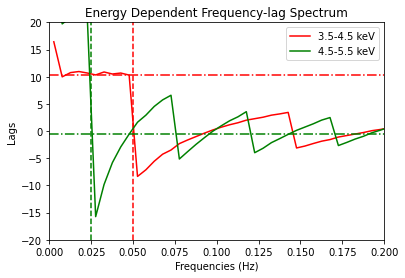

In [15]:
plt.figure()
plots = []
colors = ['r','g']
energies = ['3.5-4.5 keV', '4.5-5.5 keV']

# Plot lag-frequency spectrum
for i in range(0,len(lags)):
    plots += plt.plot(cross[i].freq, lags[i], colors[i], label=energies[i])
    plt.axvline(v_cuts[i],color=colors[i],linestyle='--')
    plt.axhline(h_cuts[i], color=colors[i], linestyle='-.')

# Define axes and add labels
plt.axis([0,0.2,-20,20])
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Lags')
plt.title('Energy Dependent Frequency-lag Spectrum')
plt.show()